<a href="https://colab.research.google.com/github/vladimiralencar/DeepLearning-LANA/blob/master/RNN/Detecc%CC%A7a%CC%83o_de_Anomalias_com_Modelos_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detecção de Anomalias com Modelos Autoencoder

É domingo de manhã e você acorda com um grande sorriso no seu rosto. Hoje será um ótimo dia! Um hora depois seu telefone toca. Você pega lentamente o aparelho e ouve o seguinte: "Eu sou Michele, sua agente pessoal do banco XPTO." O que poderia ser tão urgente para alguém do banco ligar para você domingo pela manhã? "O Senhor autorizou uma transação de R$ 3,358.65 por 100 cópias do Titanfall 2?" (Titanfall 2 é um game). Imediatamente, você começa a pensar nas últimas compras que fez e que não incluíram várias cópias do Titanfall. "Não, eu não fiz!?". A resposta de Michele é rápida e direta - "Obrigado, estamos verificando". Mas como Michele sabia que essa transação era suspeita? Afinal, você encomendou 10 novos smartphones usando o mesmo cartão de crédito na semana passada - e Michele não ligou para verificar. Algum modelo preditivo anti-fraude está ajudando Michele.

As perdas anuais de fraude global atingiram US$ 21,8 bilhões em 2015, de acordo com [Nilson Report](https://www.nilsonreport.com/upload/content_promo/The_Nilson_Report_10-17-2016.pdf). 

Cerca de 12 centavos por US$ 100 foram roubados nos EUA durante 2015. 

Neste Mini-Projeto iremos treinar uma Rede Neural de Autoencoder (implementada em Keras) em forma não supervisionada (ou semi-supervisionada) para detecção de anomalias em dados de transações de cartão de crédito. O modelo treinado será avaliado em conjuntos de dados pré-rotulados e anônimos.

Todo o Jupyter Notebook está devidamente documentado. Estude o Mini-Projeto para ter um exemplo de aplicação prática de Autoencoders em outros domínios além do reconhecimento de imagens.

In [0]:
# Imports
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraude"]

Using TensorFlow backend.


# Carregando os Dados

O conjunto de dados que vamos usar pode ser baixado do [Kaggle] (https://www.kaggle.com/dalpozz/creditcardfraud). Ele contém dados sobre transações com cartão de crédito ocorridas durante um período de dois dias, com 492 fraudes de 284.807 transações.

Todas as variáveis no conjunto de dados são numéricas. Os dados foram transformados usando transformação PCA por motivos de privacidade. Os dois recursos que não foram alterados são Time and Amount. O tempo contém os segundos decorridos entre cada transação e a primeira transação no conjunto de dados.

In [0]:
!wget 
df = pd.read_csv("creditcard.csv")

# Análise Exploratória

In [0]:
df.shape

(284807, 31)

31 colunas, 2 das quais são Time and Amount. O resto é produzido a partir da transformação PCA. Vamos verificar se há valores missing:

In [0]:
df.isnull().values.any()

False

In [0]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [0]:
pd.value_counts(df['Class'], sort = True)

0    284315
1       492
Name: Class, dtype: int64

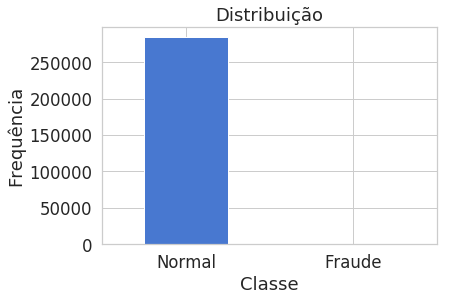

In [0]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Distribuição")
plt.xticks(range(2), LABELS)
plt.xlabel("Classe")
plt.ylabel("Frequência");

Nós temos um conjunto de dados altamente desequilibrado em nossas mãos. As transações normais dominam as fraudulentas por uma grande margem. Vejamos os dois tipos de transações:

In [0]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [0]:
frauds.shape

(492, 31)

In [0]:
normal.shape

(284315, 31)

Quão diferente é a quantidade de dinheiro usada em diferentes classes de transações?

In [0]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [0]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Vamos criar uma representação mais gráfica:

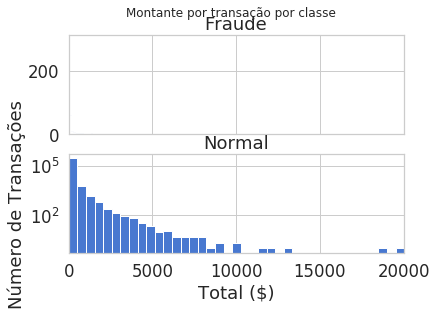

In [0]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Montante por transação por classe')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraude')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Total ($)')
plt.ylabel('Número de Transações')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

As transações fraudulentas ocorrem com mais frequência em determinados momentos? Não parece que o horário da transação realmente importa.

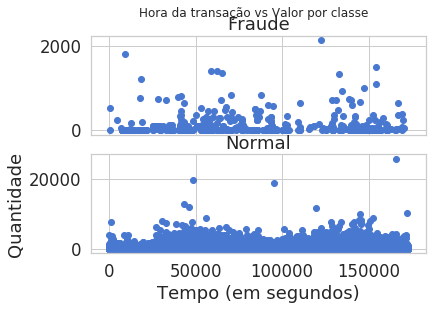

In [0]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Hora da transação vs Valor por classe')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraude')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Tempo (em segundos)')
plt.ylabel('Quantidade')
plt.show()

# Autoencoders

Os autoencoders podem parecer bastante estranhos no início. O trabalho desses modelos é prever a entrada, dada a mesma entrada. O autoencoder tenta aprender a aproximar a seguinte função de identidade:

$$\textstyle f_{W,b}(x) \approx x$$

Ao tentar fazer exatamente isso pode parecer trivial no início, mas é importante notar que queremos aprender uma representação comprimida dos dados. Isso pode ser feito limitando o número de unidades ocultas no modelo. 

Aqui está uma representação visual do que um Autoencoder pode aprender:

![](images/mushroom_encoder.png)

## Erro de Reconstrução

Otimizamos os parâmetros do nosso modelo de Autoencoder de forma a que um tipo especial de erro - erro de reconstrução seja minimizado. Na prática, o erro quadrático tradicional é frequentemente usado:

$$\textstyle L(x,x') = ||\, x - x'||^2$$

# Preperando os Dados

Primeiro, vamos remover a coluna Tempo (não a usaremos) e usar o StandardScaler do Scikit na variável Amount. O escalador remove a média e escala os valores para variância unitária:

In [0]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Treinar nosso Autoencoder vai ser um pouco diferente do que estamos acostumados. Digamos que você tenha um conjunto de dados contendo muitas transações não fraudulentas em mãos. Você deseja detectar qualquer anomalia em novas transações. Nós criaremos esta situação treinando apenas nosso modelo nas transações normais. Reservar a classe correta no conjunto de testes nos dará uma maneira de avaliar o desempenho do nosso modelo. Reservaremos 20% dos nossos dados para testes:

In [0]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [0]:
X_train.shape

(227451, 29)

# Criando o Modelo

Nosso Autoencoder usa 4 camadas totalmente conectadas com 14, 7, 7 e 29 neurônios, respectivamente. As duas primeiras camadas são usadas para o nosso codificador, as duas últimas são para o decodificador. Além disso, a regularização L1 será usada durante o treinamento:

In [0]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [0]:
input_layer = Input(shape=(input_dim, ))

# Encoder
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

# Decoder
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

# Modelo
autoencoder = Model(inputs=input_layer, outputs=decoder)

Vamos treinar nosso modelo por 100 épocas com um tamanho de lote de 32 amostras e salvar o modelo de melhor desempenho em um arquivo. O ModelCheckpoint fornecido pela Keras é realmente útil para essas tarefas. Além disso, o progresso do treinamento será exportado em um formato que possa ser lido pelo TensorBoard.

In [0]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",verbose=0,save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(X_train, X_train,
                          epochs = nb_epoch,
                          batch_size = batch_size,
                          shuffle = True,
                          validation_data = (X_test, X_test),
                          verbose = 1,
                          callbacks = [checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 8s - loss: 0.8161 - acc: 0.5835 - val_loss: 0.7925 - val_acc: 0.6461
Epoch 2/100
227451/227451 [==============================] - 8s - loss: 0.7507 - acc: 0.6546 - val_loss: 0.7753 - val_acc: 0.6625
Epoch 3/100
227451/227451 [==============================] - 8s - loss: 0.7397 - acc: 0.6674 - val_loss: 0.7665 - val_acc: 0.6739
Epoch 4/100
227451/227451 [==============================] - 8s - loss: 0.7347 - acc: 0.6728 - val_loss: 0.7712 - val_acc: 0.6654
Epoch 5/100
227451/227451 [==============================] - 8s - loss: 0.7325 - acc: 0.6754 - val_loss: 0.7637 - val_acc: 0.6700
Epoch 6/100
227451/227451 [==============================] - 8s - loss: 0.7306 - acc: 0.6771 - val_loss: 0.7620 - val_acc: 0.6766
Epoch 7/100
227451/227451 [==============================] - 8s - loss: 0.7293 - acc: 0.6785 - val_loss: 0.7606 - val_acc: 0.6864
Epoch 8/100
227451/227451 [============

227451/227451 [==============================] - 8s - loss: 0.7192 - acc: 0.6937 - val_loss: 0.7530 - val_acc: 0.6880
Epoch 64/100
227451/227451 [==============================] - 8s - loss: 0.7192 - acc: 0.6944 - val_loss: 0.7560 - val_acc: 0.6863
Epoch 65/100
227451/227451 [==============================] - 8s - loss: 0.7187 - acc: 0.6937 - val_loss: 0.7512 - val_acc: 0.6954
Epoch 66/100
227451/227451 [==============================] - 8s - loss: 0.7186 - acc: 0.6944 - val_loss: 0.7514 - val_acc: 0.6889
Epoch 67/100
227451/227451 [==============================] - 8s - loss: 0.7194 - acc: 0.6941 - val_loss: 0.7520 - val_acc: 0.6915
Epoch 68/100
227451/227451 [==============================] - 8s - loss: 0.7189 - acc: 0.6948 - val_loss: 0.7514 - val_acc: 0.6920
Epoch 69/100
227451/227451 [==============================] - 8s - loss: 0.7187 - acc: 0.6949 - val_loss: 0.7517 - val_acc: 0.6928
Epoch 70/100
227451/227451 [==============================] - 8s - loss: 0.7190 - acc: 0.6943 - 

In [0]:
autoencoder = load_model('model.h5')

# Avaliação

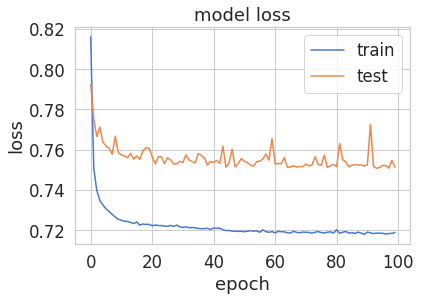

In [0]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

O erro de reconstrução em nossos dados de treinamento e teste parece convergir bem. É baixo o suficiente? Vamos dar uma olhada na distribuição de erros:

In [0]:
predictions = autoencoder.predict(X_test)

In [0]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

In [0]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.742471,0.001720
std,3.419506,0.041443
min,0.040365,0.000000
25%,0.240446,0.000000
50%,0.396927,0.000000
75%,0.625687,0.000000
max,254.064916,1.000000


## Erro de Reconstrução sem Fraude

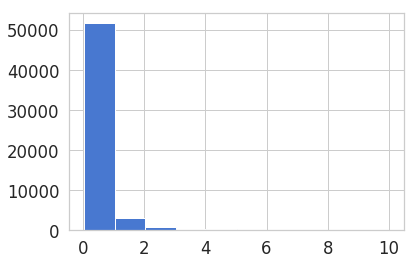

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Erro de Reconstrução com Fraude

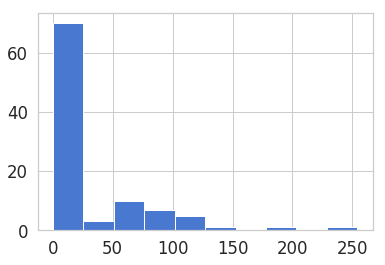

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

As curvas ROC são uma ferramenta muito útil para entender o desempenho dos classificadores binários. No entanto, nosso caso é um pouco fora do comum. Temos um conjunto de dados muito desequilibrado. No entanto, vamos dar uma olhada na nossa curva ROC:

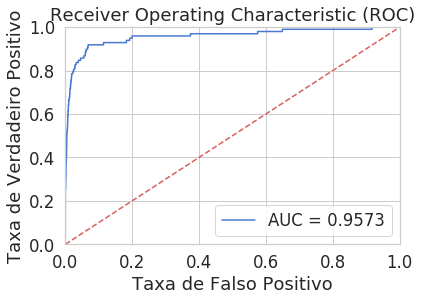

In [0]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show();

A curva ROC permite visualizar a taxa de verdadeiros positivos versus a taxa de falsos positivos, em diferentes valores. Basicamente, queremos que a linha azul seja o mais próxima possível do canto superior esquerdo. Embora nossos resultados parecem muito bons, temos que ter em mente a natureza do nosso conjunto de dados. O ROC não parece muito útil para nós. 

## Precision vs Recall

<img src="images/roc.png" />

Precisão e recall são definidos da seguinte forma:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

Vamos tirar um exemplo da Recuperação de Informações para entender melhor a precisão e o recall. A precisão mede a relevância dos resultados obtidos. Recall, por outro lado, mede quantos resultados relevantes são retornados. Ambos os valores podem ter valores entre 0 e 1. Você gostaria de ter um sistema com os dois valores iguais a 1.

Vamos retornar ao nosso exemplo da Recuperação de Informações. Recall elevada, mas Precisão baixa, significa muitos resultados, a maioria dos quais tem baixa ou nenhuma relevância. Quando a Precisão é alta, mas o Recall é baixo, temos o oposto - poucos resultados retornados com alta relevância. Idealmente, você gostaria de alta precisão e alto recall - muitos resultados altamente relevantes.

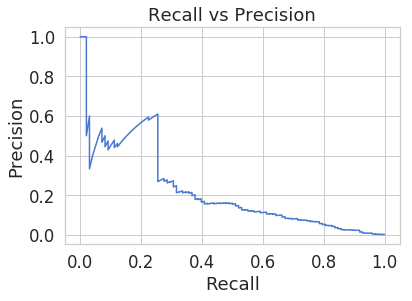

In [0]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Uma área alta sob a curva representa tanto o recall alto quanto a alta precisão, onde a alta precisão se relaciona com uma baixa taxa de falsos positivos, e o recall alto se refere a uma baixa taxa de falso negativo. Scores elevados para ambos mostram que o classificador está retornando resultados precisos (alta precisão), além de retornar a maioria de todos os resultados positivos (recall elevado).

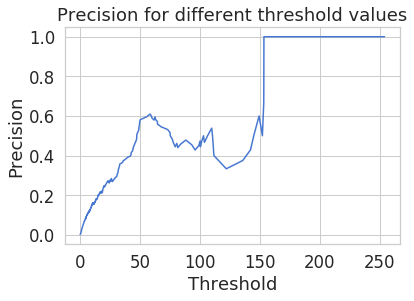

In [0]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

Você pode ver que, à medida que o erro de reconstrução aumenta, nossa precisão aumenta também. Vamos dar uma olhada no recall:

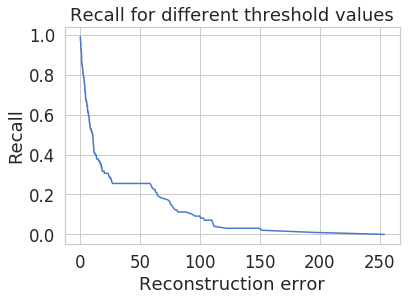

In [0]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Aqui, temos a situação exata oposta. À medida que o erro de reconstrução aumenta, a revogação diminui.

# Previsões

Nosso modelo é um pouco diferente desta vez. Não sabe como prever novos valores. Mas não precisamos disso. Para prever se uma transação nova ou não é normal ou fraudulenta, calcularemos o erro de reconstrução dos próprios dados da transação. Se o erro for maior que um limite predefinido, o marcaremos como uma fraude (já que nosso modelo deve ter um erro baixo nas transações normais). Vamos escolher esse valor:

In [0]:
threshold = 2.9

E veja o quão bem estamos dividindo os dois tipos de transações:

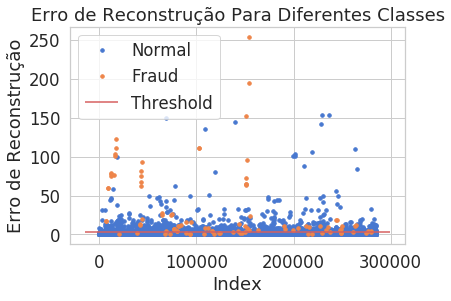

In [0]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Erro de Reconstrução Para Diferentes Classes")
plt.ylabel("Erro de Reconstrução")
plt.xlabel("Index")
plt.show();

Eu sei, essa tabela pode ser um pouco enganadora. Vamos dar uma olhada na matriz de confusão:

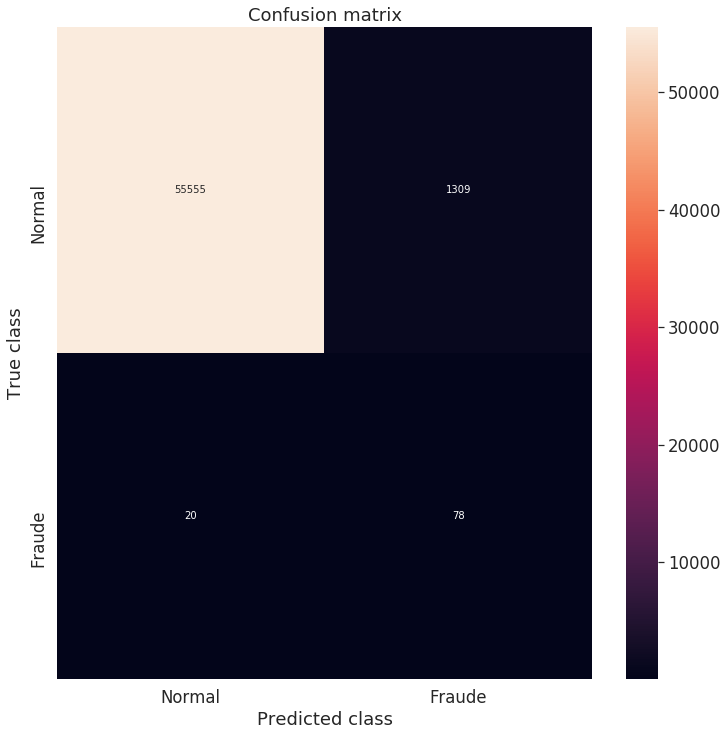

In [0]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Nosso modelo parece pegar muitos dos casos fraudulentos. O número de transações normais classificadas como fraudes é realmente alto. Isto é realmente um problema? Provavelmente é. Você pode querer aumentar ou diminuir o valor do limite, dependendo do problema. Essa é com você.

# Conclusão

Criamos um autoencoder profundo em Keras que pode reconstruir o que as transações não fraudulentas se parecem. Pense nisso, nós demos muitos exemplos de uma classe (transações normais) para um modelo e aprendemos (um pouco) como discriminar se os novos exemplos pertencem ou não a essa mesma classe. Não é legal? Nosso conjunto de dados era um pouco mágico. Nós realmente não sabemos como são as características originais.


# Referências

- [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
